# Keras 利用微調預先訓練神經網路法訓練貓狗分類器

## 透過 Kaggle API 下載 Play Dataset

先從 Kaggle 下載資料集，這裡需要註冊 Kaggle 的帳號，並且取得 API Key，記得置換為自己的 API Token 才能下載資料。

In [1]:
#!pip install kaggle
api_token = {"username":"your_username","key":"your_api_key"}
import json
import zipfile
import os

if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
!kaggle datasets download -d chetankv/dogs-cats-images

!ls -alh '/kaggle'

100% 433M/435M [00:07<00:00, 53.2MB/s]
100% 435M/435M [00:07<00:00, 62.2MB/s]
total 435M
drwxr-xr-x 2 root root 4.0K May 21 07:34 .
drwxr-xr-x 1 root root 4.0K May 21 07:34 ..
-rw-r--r-- 1 root root 435M May 21 07:34 dogs-cats-images.zip


In [0]:
!unzip 'dogs-cats-images.zip' > /dev/null

看看資料的基本結構，貓與狗訓練資料夾各有 4000 張，測試資料夾各有 1000 張影像

In [3]:
!echo "training_set cats: "
!echo `ls -alh '/kaggle/dataset/training_set/cats' | grep cat | wc -l`
!echo "training_set dogs: "
!echo `ls -alh '/kaggle/dataset/training_set/dogs' | grep dog | wc -l`
!echo "test_set cats: "
!echo `ls -alh '/kaggle/dataset/test_set/cats' | grep cat | wc -l`
!echo "test_set dogs: "
!echo `ls -alh '/kaggle/dataset/test_set/dogs' | grep dog | wc -l`

training_set cats: 
4000
training_set dogs: 
4000
test_set cats: 
1000
test_set dogs: 
1000


## 資料處理

我們上面從 Kaggle 下載的檔案全部都是圖片，由於我們想要從頭訓練一個可以分辨貓或狗的 CNN 網路，開始以前需要先將影像資料進行處理，轉換為可以送進 Keras 網路進行訓練的「張量」。並且依據我們選用的損失函數方法，處理對應標準答案的格式。

由於我們今天不會用到全部的資料，我們只會在兩種類別取用 1000 張進行訓練，500 張進行訓練驗證，500 張進行測試。

In [4]:


import os, shutil

# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '/kaggle/dataset'

# The directory where we will
# store our smaller dataset
base_dir = '/play'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)

# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1, 1001)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, 'training_set', 'cats', fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(4001, 4501)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, 'test_set', 'cats', fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(4501, 5001)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, 'test_set', 'cats', fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1, 1001)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, 'training_set', 'dogs', fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(4001, 4501)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, 'test_set', 'dogs', fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(4501, 5001)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, 'test_set', 'dogs', fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


# 使用已經訓練好的 VGG16 經典網路

這裡先取用 VGG16 CNN Base，用來擷取特徵，後面會比較對 CNN Base 重新訓練的效果差異。

In [5]:
# 載入 VGG 網路 Convolutional Base
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,             # 不包含 Full Connection
                  input_shape=(150, 150, 3))

conv_base.summary()

Using TensorFlow backend.


58892288/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

輸入要訓練的影像到 VGG16 CNN Base 獲取 predict 後的特徵值。


In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

# 比較「特徵擷取法」與「微調預先訓練神經網路法」的差異

先實做基本的特徵擷取法 (可以參考前一個章節)，把剛剛透過 CNN Base 得到的特徵送進網路進行訓練，回顧一下作法順便比較。

### 特徵擷取法：大約 90% 正確率


In [8]:

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 470us/step - loss: 0.6093 - acc: 0.6625 - val_loss: 0.4944 - val_acc: 0.7920
Epoch 2/30
2000/2000 [==============================] - 1s 341us/step - loss: 0.4558 - acc: 0.7980 - val_loss: 0.3934 - val_acc: 0.8490
Epoch 3/30
2000/2000 [==============================] 

## 圖表分析「特徵擷取法」訓練結果

一般的特徵擷取法正確率大約 0.9 左右。

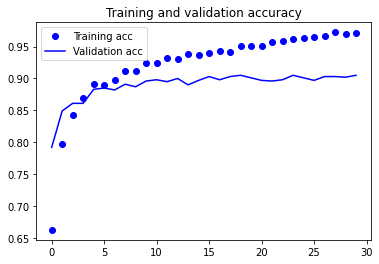

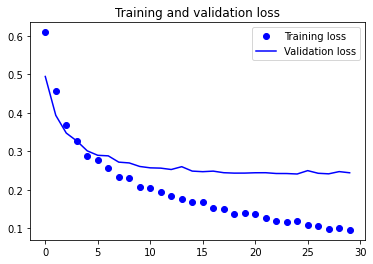

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 微調預先訓練神經網路法

這裡我們要聯合 VGG16 CNN Base 進行學習，解凍 (Freeze) 一些卷積基底「頂部」的某些層用於特徵擷取，並對新加入的 Full Connection Layer 進行聯合訓練。由於稍稍調整了原本 CNN 基底的表示法，所以叫做「微調」。

開始以前，我們先只是進行聯合學習，使用 VGG16 CNN Base 接上我們自己的 Full Connection Layer 進行完整的學習。對於 VGG16 CNN 的參數是「凍結」的狀態。

### 預先訓練神經網路法(凍結 CNN)：大約 96% 正確率



In [10]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 48s - loss: 0.4902 - acc: 0.7415 - val_loss: 0.3136 - val_acc: 0.9190
Epoch 2/30
 - 44s - loss: 0.2650 - acc: 0.8890 - val_loss: 0.0772 - val_acc: 0.9200
Epoch 3/30
 - 44s - loss: 0.2257 - acc: 0.9135 - val_loss: 0.6628 - val_acc: 0.9580
Epoch 4/30
 - 44s - loss: 0.1787 - acc: 0.9290 - val_loss: 0.0328 - val_acc: 0.9460
Epoch 5/30
 - 44s - loss: 0.1702 - acc: 0.9305 - val_loss: 0.0387 - val_acc: 0.9610
Epoch 6/30
 - 44s - loss: 0.1335 - acc: 0.9455 - val_loss: 0.5476 - val_acc: 0.8800
Epoch 7/30
 - 44s - loss: 0.1159 - acc: 0.9575 - val_loss: 0.0575 - val_acc: 0.9510
Epoch 8/30
 - 44s - loss: 0.1122 - acc: 0.9575 - val_loss: 0.0474 - val_acc: 0.9650
Epoch 9/30
 - 44s - loss: 0.0870 - acc: 0.9685 - val_loss: 0.0471 - val_acc: 0.9640
Epoch 10/30
 - 44s - loss: 0.0951 - acc: 0.9635 - val_loss: 0.2937 - val_acc: 0.9110
Epoch 11/30
 - 44s - loss: 0.0865 - acc: 0.9675 - val_loss: 0.3589 - val_ac

## 看圖分析訓練成果 - 預先訓練神經網路法(凍結 CNN)：大約 96% 正確率

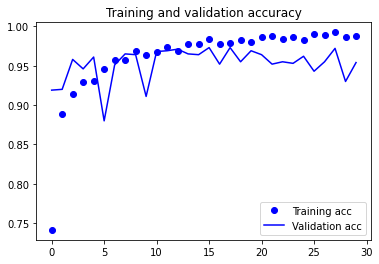

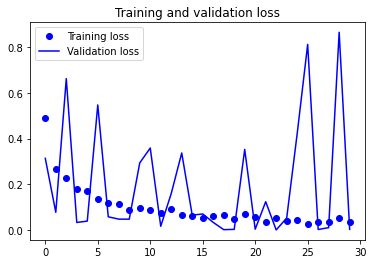

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 微調預先訓練神經網路法 (解凍 VGG16 block5_conv1)

剛剛在套用 VGG16 CNN Base 進行聯合訓練可以到達 96% 準確率，接下來我們要進行「微調」，就是解凍部份已經訓練好的 CNN 網路，藉此提高模型擬合我們新資料的能力。

這裡的實驗只有解凍 VGG16 最後一層 (第五層) 的網路權重，並且使用「低學習率」進行調整。解凍網路的方式如下，解凍後要重新 Compile：

In [0]:
conv_base.trainable = True

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        layer.trainable = True         # 解凍 CNN 基底
    else:
        layer.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),  # 低學習率
              metrics=['acc'])

# 重新訓練網路並進行微調

In [14]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 29s 289ms/step - loss: 0.0126 - acc: 0.9955 - val_loss: 0.3343 - val_acc: 0.9690
Epoch 2/100
100/100 [==============================] - 27s 268ms/step - loss: 0.0127 - acc: 0.9965 - val_loss: 0.0088 - val_acc: 0.9690
Epoch 3/100
100/100 [==============================] - 27s 269ms/step - loss: 0.0159 - acc: 0.9940 - val_loss: 1.0229 - val_acc: 0.9690
Epoch 4/100
100/100 [==============================] - 27s 268ms/step - loss: 0.0185 - acc: 0.9960 - val_loss: 2.7910e-04 - val_acc: 0.9700
Epoch 5/100
100/100 [==============================] - 27s 268ms/step - loss: 0.0114 - acc: 0.9965 - val_loss: 0.3581 - val_acc: 0.9700
Epoch 6/100
100/100 [==============================] - 27s 267ms/step - loss: 0.0097 - acc: 0.9960 - val_loss: 0.0018 - val_acc: 0.9700
Epoch 7/100
100/100 [==============================] - 27s 267ms/step - loss: 0.0050 - acc: 0.9970 - val_loss: 0.3982 - val_acc: 0.9710
Epoch 8/100
100/100 [=======================

## 透過圖表進行分析 - 預先訓練神經網路法(凍結 CNN)：大約 97% 正確率

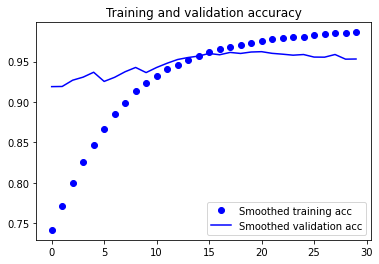

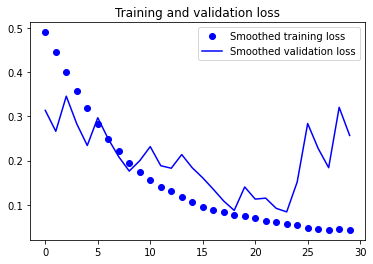

In [15]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.972000002861023


採用「預先訓練神經網路法(凍結 CNN)」，使用 Test Dataset 進行評估，大約可以提高到 97% 正確率。